In [1]:
from __future__ import print_function, division
import numpy
from PyAstronomy.pyaC import pyaErrors as PE
import six.moves as smo

class Scanner:
  
  def __init__(self, minVal=0.1, maxVal=10.0, dVal=0.05, mode="period"):
    """
      The Scanner class is used to define the period/frequency range and steps used in the \
      PDM analysis. It is iteratable.
      
      Parameters:
        - `minVal` - float, Minimum value,
        - `maxVal` - float, Maximum value,
        - `dVal`   - float, Delta value,
        - `mode`   - string, optional, Either "period" or "frequency" (default = "period").
      
      .. Note: Whether min, max, and dval refer to period or frequency depends on the ``mode'' parameter.
      .. Note: Time units have match the time axis given to the PDM analysis class.
    """
    if (mode != "period") and (mode != "frequency"):
      raise(PE.PyAValError("`mode` must either be 'period' or 'frequency'. Current value is: "+str(mode), \
                           where="Scanner::__init__", solution="Choose either 'period' or 'frequency' for mode parameter."))
    self.minVal = minVal
    self.maxVal = maxVal
    self.dVal = dVal
    self.mode = mode
  
  def __iter__(self):
    self.curVal = self.minVal
    while self.curVal <= self.maxVal:
      yield self.curVal
      self.curVal += self.dVal



class PyPDMmod:
  
  def __init__(self, time, mag):
    """
      This class allows to carry out a ``Phase Dispersion Minimization'' (PDM) analysis as described in
      Stellingwerf 1978.
      
      Parameters:
       - time - array, The time array (arbitrary time units),
       - mag - array, The corresponding flux in magnitudes. 
      
      Properties:
       - minBinPoints - The minimum number of data points,
                        which may be contained in an individual bin (default = 3).
    """
    # The minimum number of data points per bin.
    self.minBinPoints = 3
    # Save the data
    self.x = time.copy()
    self.y = mag.copy()
  
  def __setUpEquiBlocks(self, nbins, phases):
    """
      Set up a sequence of equidistant bins. Then check whether all bins contain enough data points \
      (defined by minBinPoints property). \
      If this is not the case, the border to the adjacent bin with fewer photons is dropped. Therefore,
      the resulting bins are not necessarily equidistant anymore.
      
      Parameters:
       - nbins - int, The number of bins.
       - phases - array, The phases of the data points. 
      
      Returns: A list with the beginnings and one list with the ends of the bins (in phase). 
    """
    blockBegin = (numpy.arange(nbins) / float(nbins)).tolist()
    blockEnd   = ((numpy.arange(nbins) + 1.0) / float(nbins)).tolist()
    Ns = []
    for i in smo.range(nbins):
      indi = numpy.where(numpy.logical_and(phases >= blockBegin[i], phases < blockEnd[i]))[0]
      Ns.append(len(indi))
    
    i = 0
    while(i < len(Ns)):
      if Ns[i] < self.minBinPoints:
        # The bin with number i does not contain enough data points.
        # Remove the border to make the bins larger...
        iPlus = i + 1
        iMinu = i - 1
        NPlus = 0; NMinu = 0
        if iPlus == len(blockEnd):
          NPlus = 1e100
        else:
          NPlus = Ns[iPlus]
        if iMinu == -1:
          NMinu = 1e100
        else:
          NMinu = Ns[iMinu]
        if NMinu <= NPlus:
          # Eliminate the border to bin below
          blockBegin.pop(i); blockEnd.pop(i-1)
          Ns[i] = Ns[i-1] + Ns[i]; Ns.pop(i-1)
          # Reiterate
          i = 0
          continue
        else:
          # Eliminate the border to bin behind
          blockBegin.pop(i+1); blockEnd.pop(i)
          Ns[i+1] = Ns[i] + Ns[i+1]; Ns.pop(i)
          # Reiterate
          i = 0
          continue
      i += 1
    return blockBegin, blockEnd

  def __setUpEquiBlocksCover(self, nbins, phases, covers):
    """
      Set up a sequence of equidistant bins. Then reproduce the same sequence but offset by \
      1/(nbins*covers). In this vein, data points are covered by multiple bins. The phase \
      axis is cyclic. This function pays no attention to the number of data points within \
      individual bins.
      
      Parameters:
       - nbins - int, The number of bins.
       - phases - array, The phases of the data points. 
       - covers - int, The number of covers (as explained above).
      
      Returns: A list with the beginnings and one list with the ends of the bins (in phase). 
    """
    blockBegin = numpy.arange(nbins) / float(nbins)
    blockEnd   = (numpy.arange(nbins) + 1.0) / float(nbins)
    
    blockBeginOrig = blockBegin.copy()
    blockEndOrig = blockEnd.copy()
    
    offset = 0
    for i in smo.range(1,covers):
      offset = float(i)/float(nbins * covers)
      blockBegin = numpy.append(blockBegin, blockBeginOrig + offset)
      blockEnd   = numpy.append(blockEnd, blockEndOrig + offset)
      
    return blockBegin, blockEnd

  def phase(self, time, period):
    """
      Calculate phases and ordering.
    
      Parameter:
        - `time` - array, Time stamps,
        - `period` - float, The period used to calculate phases.
    
      Returns:
        An unsorted phase array and an array with indices specifying the order. Thus,
        phase[indi], mag[indi] is the phase-sorted phased light curve.
    """
    phase = time/period - numpy.floor(time/period)
    indi = numpy.argsort(phase)
    return phase, indi
  
  def __getThet(self, phase, mag, bbegin, bend):
    """
      Calculate the Theta statistics defined by Stellinger '78.
      
      Parameters:
       - phase, mag - arrays, Phase-sorted(!) light curve.
       - bbegin, bend -lists, begin and end of individual bins (``blocks'').
      
      Returns the value of Theta.
    """
    meanMag = mag.mean()
    N = len(mag)
    M = len(bbegin)
    sigmaSqr = ((mag - meanMag)**2).sum() / float(N - 1)

    sSqrUp = 0.0; sSqrDown = 0.0
    for i in smo.range(len(bbegin)):
      # Points belonging to a chunk
      indi = numpy.where(numpy.logical_and(phase >= bbegin[i], phase < bend[i]))[0]
      nj = float(len(indi))
      if nj > 1:
        # Variance of individual block
        sigmaj = ((mag[indi] - mag[indi].mean())**2).sum() / float(nj - 1)
        sSqrUp += (nj - 1)*sigmaj
        sSqrDown += nj
        #print(M)
    sSqrDown -= M
    
    sSqr = sSqrUp / sSqrDown
    theta = sSqr / sigmaSqr
    return theta, sSqrDown
  
  def pdmEquiBin(self, nbins, scanner):
    """
      Carry out the PDM analysis using equidistant bins.
      
      This method uses equidistant bins, yet, it pays attention to the number of \
      data points contained in individual bins. If this number is insufficient \
      (as defined by the `minBinPoints` property), adjacent bins are combined
      (see documentation of *__setUpEquiBlocks*).
      
      Parameters:
        - `nbins` - int, Number of bins to use.
        - `scanner` - An instance of the *Scanner* class, defining, which periods/frequencies
                      are tested.
      
      Returns two arrays: the periods and the associated values of the Theta statistic. These
      are also saved to the class properties `periods`, `frequencies`, and `theta`.
      .. Note:: Whether the first return value is frequency or period
                depends on the mode of the scanner.
    """
    # Go through periods
    periods = []; theta = [];downs = [];
    for val in scanner:
      if scanner.mode == "period":
        period = val
      else:
        period = 1.0/val
      # Note the p[indi], self.y[indi] is the ordered, phased light curve
      p, indi = self.phase(self.x, period)
      bbegin, bend = self.__setUpEquiBlocks(nbins, p[indi])
      periods.append(period)
      theta.append(self.__getThet(p[indi], self.y[indi], bbegin, bend)[0])
      downs.append(self.__getThet(p[indi], self.y[indi], bbegin, bend)[1])
    
    # Save result
    self.periods = numpy.array(periods)
    self.frequencies = 1.0 / numpy.array(periods)
    self.theta = numpy.array(theta)
    
    if scanner.mode == "period":
      return self.periods.copy(), self.theta.copy(), downs
    else:
      return self.frequencies.copy(), self.theta.copy()

  def pdmEquiBinCover(self, nbins, covers, scanner):
    """
      Carry out the PDM analysis using multiple sequences of equidistant bins.
      
      The bins used by this method are equidistant, but the phase axis and, thus, \
      the data points are covered by multiple bins. The first sequence of bins is \
      the usual devision of the 0-1 interval into *nbins* bins; the following sequences \
      are the same but offset of 1/(nbins*covers) in phase (the phase axis is cyclic).
      
      This method does not check whether bins contain "enough" data points, i.e., it neglects \
      the `minBinPoints` property taken into account by *pdmEquiBin*. If, however, less than \
      two data points are contained within a bin, it is neglected.
      
      Parameters:
        - `nbins` - int, Number of bins to use.
        - `scanner` - An instance of the *Scanner* class, defining, which periods/frequencies are tested.
        - `covers` - int, The number of covers, i.e., phase-shifted bin sets.
      
      Returns two arrays: the periods/frequencies and the associated values of the Theta statistic. These
      are also saved to the class properties ``periods'', ``frequencies'', and ``theta''.
      
      .. Note:: Whether the first return value is frequency or period depends on the mode of the scanner.
    """
    # Go through periods
    periods = []; theta = []
    for val in scanner:
      if scanner.mode == "period":
        period = val
      else:
        period = 1.0/val
      # Note the p[indi], self.y[indi] is the ordered, phased light curve
      p, indi = self.phase(self.x, period)
      # Extend phase and mag arrays to allow for phases > 1.0 (cyclic phase array...)
      phase = numpy.append(p[indi], p[indi]+1.0)
      mag = numpy.append(self.y[indi], self.y[indi])
      bbegin, bend = self.__setUpEquiBlocksCover(nbins, phase, covers)
      periods.append(period)
      theta.append(self.__getThet(phase, mag, bbegin, bend))
    
    # Save result
    self.periods = numpy.array(periods)
    self.frequencies = 1.0 / numpy.array(periods)
    self.theta = numpy.array(theta)
    
    if scanner.mode == "period":
      return self.periods.copy(), self.theta.copy()
    else:
      return self.frequencies.copy(), self.theta.copy()
    
    
    
    

In [2]:
from PyAstronomy.pyTiming import pyPDM
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.ticker
import scipy.integrate as integrate
from scipy.stats import f

In [3]:
cp ../../u9712005/*18.npy .

In [4]:
name = 'u18'
mjd = np.load('mjd'+name+'.npy')
mag = np.load('mag'+name+'.npy')
dmag = np.load('dmag'+name+'.npy')
obnames = np.load('obnames'+name+'.npy')
time = np.load('time'+name+'.npy')


In [5]:
# Get a ``scanner'', which defines the frequency interval to be checked.
# Alternatively, also periods could be used instead of frequency.
S = Scanner(minVal=0.3, maxVal=3. ,dVal=0.001, mode="period")

# Carry out PDM analysis. Get frequency array
# (f, note that it is frequency, because the scanner's
# mode is ``frequency'') and associated Theta statistic (t).
# Use 10 phase bins and 3 covers (= phase-shifted set of bins).
P = PyPDMmod(mjd, mag)
f1, t1,downs = P.pdmEquiBin(10,S)

#f1, t1 = P.pdmEquiBinCover(10, 3, S)

thetadic = {'theta':t1,
           'period':f1}  

# Show the result




In [6]:
wheremin = np.argmin(thetadic['theta'])
periodbest = thetadic['period'][wheremin]
thetabest = thetadic['theta'][wheremin]
Nfatbest = downs[wheremin]
print(wheremin)
print(thetabest,periodbest,Nfatbest)


1685
0.17491490438736132 1.984999999999892 104.0


In [7]:
limit = Nfatbest* thetabest
limit

18.191150056285576

If N is large(>100). Here P is twice the area of the chi^2 distribution below Nf times Theta. Where nf is Sum nj -M. So denominator equation to get variance

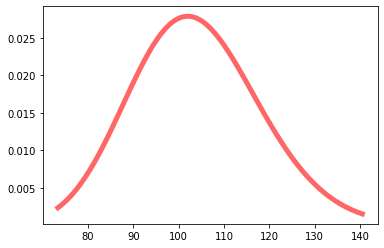

In [8]:
df = Nfatbest
vals = chi2.ppf([0.001, 0.5, 0.999], df)
chi2.cdf(vals, df)
x = np.linspace(chi2.ppf(0.01, df),
                chi2.ppf(0.99, df), 100)
plt.plot(x, chi2.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='chi2 pdf')

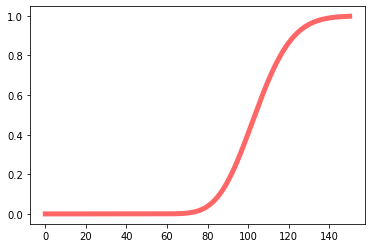

In [9]:
x2 = np.linspace(0,150,10000)
vals = chi2.cdf(x2, df)

plt.plot(x2, vals,
       'r-', lw=5, alpha=0.6, label='chi2 pdf')

## Fisher

In [10]:
df1 ,df2 = 59,56
thetaexamplefisher = 0.4
sigmalimitfisher = 1/thetaexamplefisher

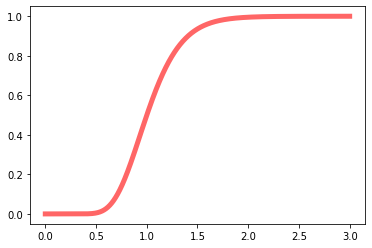

In [11]:
x2cdffisher = np.linspace(0,3,1000000)
cdffisher = f.cdf(x2cdffisher, df1,df2)
plt.plot(x2cdffisher, cdffisher,
       'r-', lw=5, alpha=0.6)

# pdf

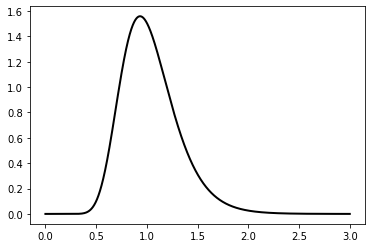

In [12]:
rvfisher = f(df1, df2)
plt.plot(x2cdffisher, rvfisher.pdf(x2cdffisher), 'k-', lw=2, label='frozen pdf')

In [13]:
limitfx = np.where(x2cdffisher >= sigmalimitfisher)
fxfexample = limitfx[0]
limitlowf,limithighf = x2cdffisher[fxfexample[0]], x2cdffisher[fxfexample[-1]]
resultf = integrate.quad(lambda x: rvfisher.pdf(x), limitlowf, limithighf)
print(resultf)

(0.00032759478737953577, 3.637032756959432e-18)


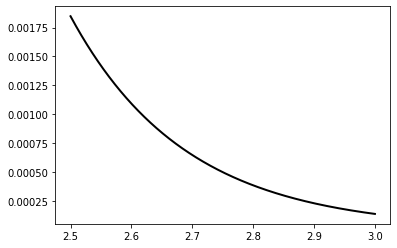

In [14]:
lowind = np.argmin(abs(x2cdffisher-limitlowf))
highind = np.argmin(abs(x2cdffisher-limithighf))
plt.plot(x2cdffisher[lowind:highind], rvfisher.pdf(x2cdffisher[lowind:highind]), 'k-', lw=2, label='frozen pdf')

In [15]:
pf = 2*resultf[0]
print(pf)

0.0006551895747590715


# My data

## Fisher

In [16]:
df1 ,df2 = 112,104
thetaexamplefisher = thetabest
sigmalimitfisher = 1/thetaexamplefisher

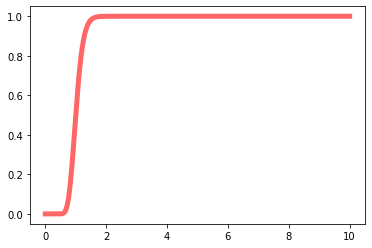

In [17]:
x2cdffisher = np.linspace(0,10,1000000)
cdffisher = f.cdf(x2cdffisher, df1,df2)
plt.plot(x2cdffisher, cdffisher,
       'r-', lw=5, alpha=0.6)

# pdf

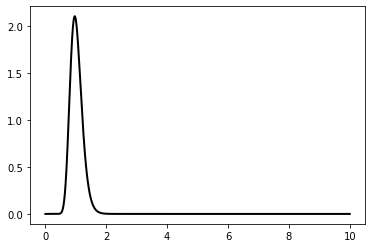

In [18]:
rvfisher = f(df1, df2)
plt.plot(x2cdffisher, rvfisher.pdf(x2cdffisher), 'k-', lw=2, label='frozen pdf')

In [19]:
limitfx = np.where(x2cdffisher >= sigmalimitfisher)
fxfexample = limitfx[0]
limitlowf,limithighf = x2cdffisher[fxfexample[0]], x2cdffisher[fxfexample[-1]]
resultf = integrate.quad(lambda x: rvfisher.pdf(x), limitlowf, limithighf)
print(resultf)

(1.3103253283594064e-17, 2.7335135955617477e-21)


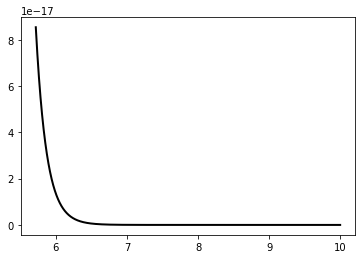

In [20]:
lowind = np.argmin(abs(x2cdffisher-limitlowf))
highind = np.argmin(abs(x2cdffisher-limithighf))
plt.plot(x2cdffisher[lowind:highind], rvfisher.pdf(x2cdffisher[lowind:highind]), 'k-', lw=2, label='frozen pdf')

In [21]:
pf = 2*resultf[0]
print(pf)

2.6206506567188128e-17


In [22]:
sigmalimitfisher

5.7170656983319725

In [23]:
1/10000000.

1e-07

In [24]:
0.0815129275321623

0.0815129275321623

0.055955126818900094

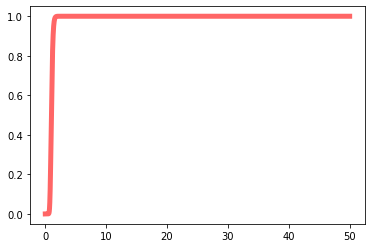

In [25]:
x2fisher = np.linspace(0,50,10000)
valsfisher = f.cdf(x2fisher, df1,df2)

plt.plot(x2fisher, valsfisher,
       'r-', lw=5, alpha=0.6, label='chi2 pdf')

In [26]:
limitf = (1/thetaexamplefisher)/100.
limitfx = np.where(valsfisher >= limitf)
fxfexample = limitfx[0][-1]

In [185]:
resultfexample = integrate.quad(lambda x: f.cdf(x, df1,df2), 0, x2fisher[fxfexample])

In [186]:
resultfexample

(48.96296296296296, 6.39585161091652e-11)

istwicetheareaof the F distribution above 1/theta

(0, 0.03)

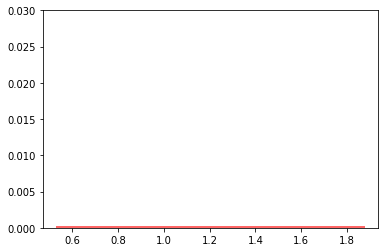

In [171]:
valsfpdf = f.ppf([0.001, 0.5, 0.9], df1,df2)
xfpdf = np.linspace(f.ppf(0.01, df1,df2),
                f.ppf(0.99, df1,df2), 100)
plt.plot(xfpdf , chi2.pdf(xfpdf, df1,df2),
       'r-', lw=5, alpha=0.6, label='chi2 pdf')
plt.ylim(0, 0.03)

In [118]:
vals = chi2.ppf(np.linspace(0,0.9,100), df)
result = integrate.quad(lambda x: chi2.pdf(x, df), 0, 150)

In [140]:
df2

56

In [120]:
np.where(x2 < limit/100.)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),)

In [111]:
x2

array([  0.        ,   1.51515152,   3.03030303,   4.54545455,
         6.06060606,   7.57575758,   9.09090909,  10.60606061,
        12.12121212,  13.63636364,  15.15151515,  16.66666667,
        18.18181818,  19.6969697 ,  21.21212121,  22.72727273,
        24.24242424,  25.75757576,  27.27272727,  28.78787879,
        30.3030303 ,  31.81818182,  33.33333333,  34.84848485,
        36.36363636,  37.87878788,  39.39393939,  40.90909091,
        42.42424242,  43.93939394,  45.45454545,  46.96969697,
        48.48484848,  50.        ,  51.51515152,  53.03030303,
        54.54545455,  56.06060606,  57.57575758,  59.09090909,
        60.60606061,  62.12121212,  63.63636364,  65.15151515,
        66.66666667,  68.18181818,  69.6969697 ,  71.21212121,
        72.72727273,  74.24242424,  75.75757576,  77.27272727,
        78.78787879,  80.3030303 ,  81.81818182,  83.33333333,
        84.84848485,  86.36363636,  87.87878788,  89.39393939,
        90.90909091,  92.42424242,  93.93939394,  95.45